This will adapt structure window size

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [5]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks"""

    regularizer = tf.keras.regularizers.l2(0.01)

    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # Structure track
    # Structure track with adaptive dense layer size
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)

    struct_positions = 1 + (2 * struct_window)
    total_struct_features = struct_positions * struct_features
    
    # Make dense layer size proportional to input features
    struct_dense_size = min(total_struct_features * 2, 128)  # or another scaling rule
        
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct]))
    
    # Apply weights using layers
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    # Combine weighted features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)
    
    def get_track_weights():
        # Get the weights and bias from the weight layer
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            # Calculate softmax
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1])
            }
        return {'sequence': 0.5, 'structure': 0.5}
    
    model.get_track_weights = get_track_weights
    
    return model

In [12]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
        
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
        
    return model

Loading data...

Training set distribution:
label
1    4592
0    4261
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8853, 33)
X_train_struct: (8853, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8853,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-15 11:17:58.642056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-15 11:17:58.642082: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-15 11:17:58.642099: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-15 11:17:58.642117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 11:17:58.642129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-15 11:17:59.592377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5307 - loss: 1.2133 - val_accuracy: 0.5042 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5872 - loss: 0.8344 - val_accuracy: 0.5082 - val_loss: 0.7959 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6339 - loss: 0.7352 - val_accuracy: 0.5596 - val_loss: 0.7742 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6669 - loss: 0.7045 - val_accuracy: 0.6736 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6990 - loss: 0.6662 - val_accuracy: 0.6787 - val_loss: 0.6476 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7203 - loss: 0.6262 - val_accuracy: 0.6945 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7377 - loss: 0.6065 - val

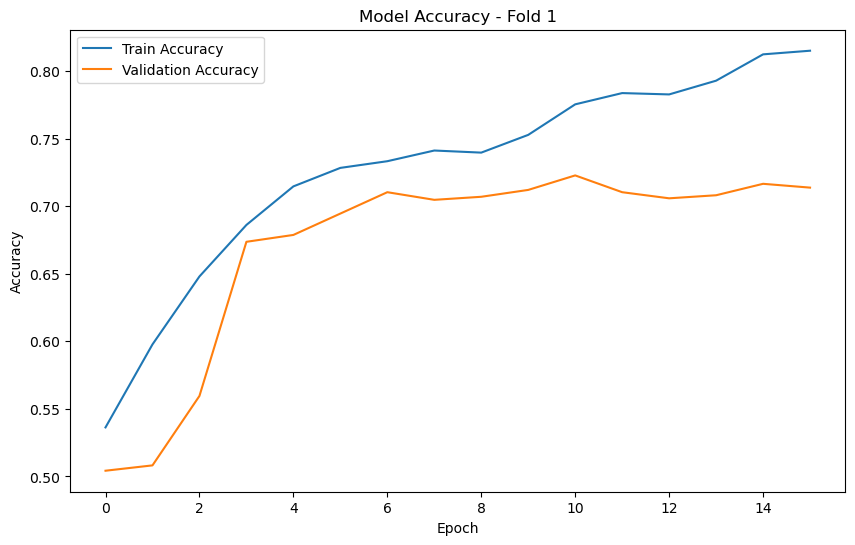

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7228
Balanced Accuracy: 0.7228
MCC: 0.4490
Sensitivity: 0.7842
Specificity: 0.6614

Learned track weights for fold 1:
Sequence weight: 0.5948
Structure weight: 0.4052

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5091 - loss: 1.2277 - val_accuracy: 0.5325 - val_loss: 0.9117 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6176 - loss: 0.8392 - val_accuracy: 0.5850 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6570 - loss: 0.7420 - val_accuracy: 0.6623 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6849 - loss: 0.6961 - val_accuracy: 0.6951 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7175 - loss: 0.6559 - val_accuracy: 0.6070 - val_loss: 0.7227 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7151 - loss: 0.6490 - val_accuracy: 0.6431 - val_loss: 0.7491 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7181 - loss: 0.6450 - val

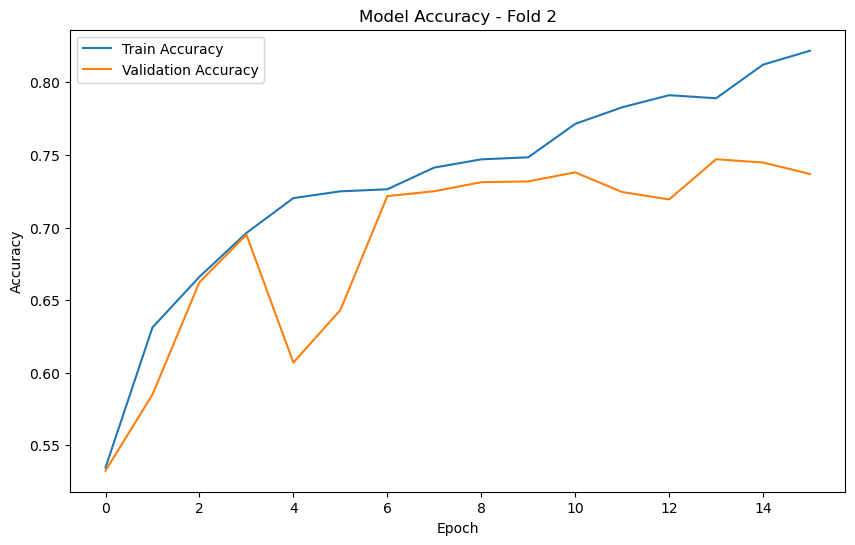

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7380
Balanced Accuracy: 0.7225
MCC: 0.4736
Sensitivity: 0.8778
Specificity: 0.5671

Learned track weights for fold 2:
Sequence weight: 0.5768
Structure weight: 0.4232

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.5226 - loss: 1.1941 - val_accuracy: 0.5110 - val_loss: 0.8886 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6230 - loss: 0.8020 - val_accuracy: 0.5121 - val_loss: 0.8349 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6608 - loss: 0.7250 - val_accuracy: 0.6008 - val_loss: 0.7382 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6904 - loss: 0.6715 - val_accuracy: 0.7069 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7123 - loss: 0.6436 - val_accuracy: 0.6239 - val_loss: 0.7254 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7183 - loss: 0.6285 - val_accuracy: 0.7109 - val_loss: 0.6384 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7399 - loss: 0.6086 - val

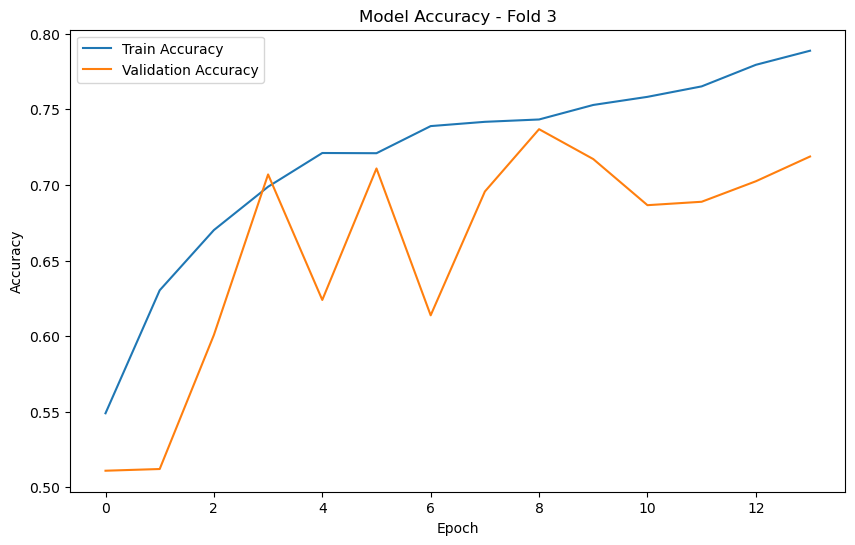

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7369
Balanced Accuracy: 0.7348
MCC: 0.4792
Sensitivity: 0.8298
Specificity: 0.6397

Learned track weights for fold 3:
Sequence weight: 0.5834
Structure weight: 0.4166

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5368 - loss: 1.1746 - val_accuracy: 0.5147 - val_loss: 0.8880 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6344 - loss: 0.7999 - val_accuracy: 0.5254 - val_loss: 0.7934 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6764 - loss: 0.7099 - val_accuracy: 0.5412 - val_loss: 0.8035 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6995 - loss: 0.6737 - val_accuracy: 0.6893 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7237 - loss: 0.6301 - val_accuracy: 0.7045 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7371 - loss: 0.6178 - val_accuracy: 0.6881 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7499 - loss: 0.6009 - val

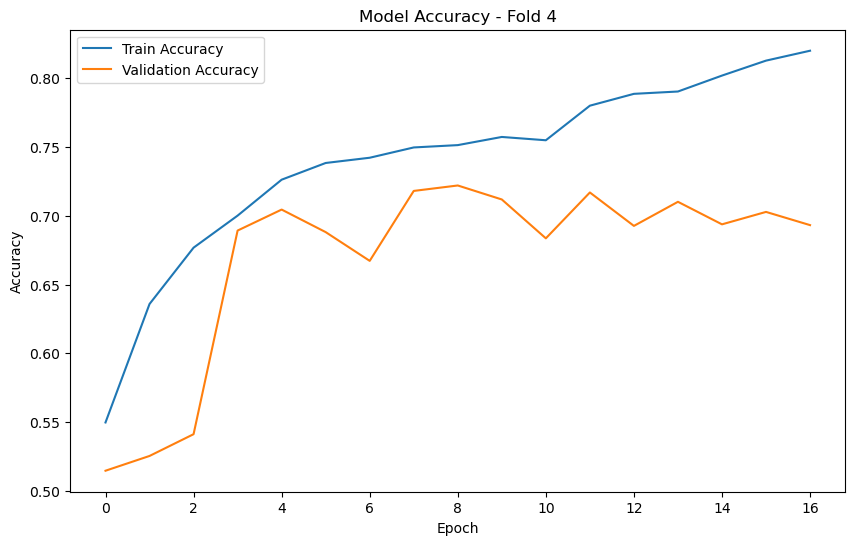

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7169
Balanced Accuracy: 0.7129
MCC: 0.4442
Sensitivity: 0.8496
Specificity: 0.5763

Learned track weights for fold 4:
Sequence weight: 0.5993
Structure weight: 0.4007

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5188 - loss: 1.1757 - val_accuracy: 0.5299 - val_loss: 0.8662 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5905 - loss: 0.8181 - val_accuracy: 0.5751 - val_loss: 0.7860 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6494 - loss: 0.7295 - val_accuracy: 0.6565 - val_loss: 0.7367 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7079 - loss: 0.6745 - val_accuracy: 0.7073 - val_loss: 0.6489 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7090 - loss: 0.6429 - val_accuracy: 0.7164 - val_loss: 0.6211 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7214 - loss: 0.6210 - val_accuracy: 0.7164 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7433 - loss: 0.6050 - val

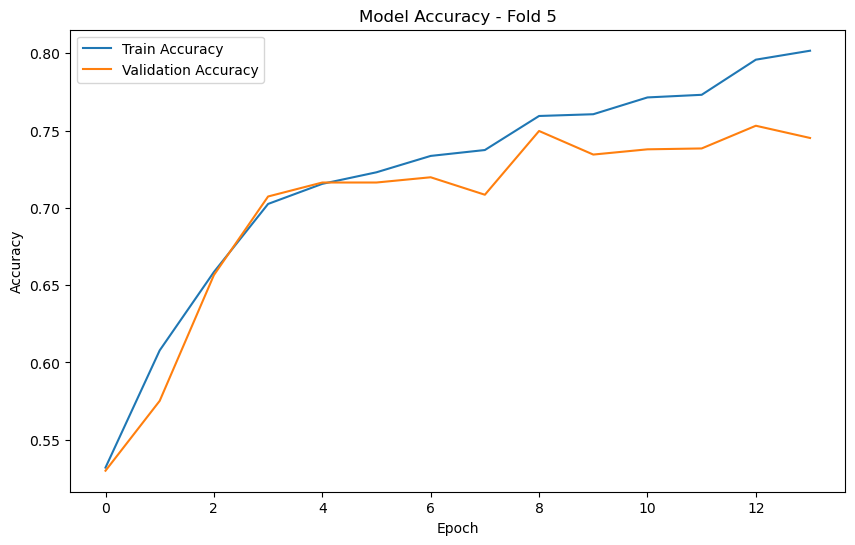

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7497
Balanced Accuracy: 0.7467
MCC: 0.5017
Sensitivity: 0.8299
Specificity: 0.6635

Learned track weights for fold 5:
Sequence weight: 0.5694
Structure weight: 0.4306

Average track weights across folds:
Sequence weight: 0.5847 ± 0.0111
Structure weight: 0.4153 ± 0.0111

Average Cross-validation Results:
ACC: 0.7329 ± 0.0117
BALANCED_ACC: 0.7279 ± 0.0117
MCC: 0.4695 ± 0.0210
SN: 0.8343 ± 0.0306
SP: 0.6216 ± 0.0417

Final Test Set Results:
Accuracy: 0.6485
Balanced Accuracy: 0.7471
MCC: 0.2836
Sensitivity: 0.8667
Specificity: 0.6276
Confusion Matrix:
[[1567  930]
 [  32  208]]


In [13]:
if __name__ == "__main__":
    model = train_and_evaluate()

Loading data...

Training set distribution:
label
1    4592
0    4261
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8853, 33)
X_train_struct: (8853, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8853,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.5146 - loss: 1.1542 - val_accuracy: 0.5415 - val_loss: 0.8531 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6114 - loss: 0.7988 - val_accuracy: 0.5014 - val_loss: 0.8737 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6738 - loss: 0.7111 - val_accuracy: 0.5025 - val_loss: 1.0911 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6965 - loss: 0.6797 - val_accuracy: 0.6477 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7103 - loss: 0.6468 - val_accuracy: 0.6347 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7309 - loss: 0.6173 - val_accuracy: 0.7115 - val_loss: 0.6238 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7220 - loss: 0

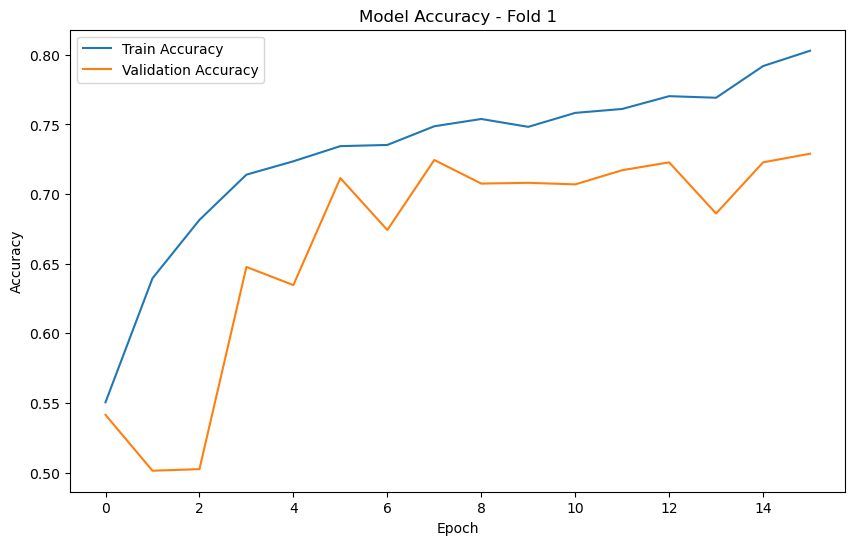

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7069
Balanced Accuracy: 0.7070
MCC: 0.4149
Sensitivity: 0.7412
Specificity: 0.6727

Learned track weights for fold 1:
Sequence weight: 0.5395
Structure weight: 0.4605

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5294 - loss: 1.1171 - val_accuracy: 0.4500 - val_loss: 0.8595 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6553 - loss: 0.7363 - val_accuracy: 0.4500 - val_loss: 0.9794 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6830 - loss: 0.6786 - val_accuracy: 0.4512 - val_loss: 1.0289 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7075 - loss: 0.6498 - val_accuracy: 0.5138 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7336 - loss: 0.6133 - val_accuracy: 0.6420 - val_loss: 0.6872 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7405 - loss: 0.5825 - val_accuracy: 0.6358 - val_loss: 0.7055 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7476 - loss: 0.5

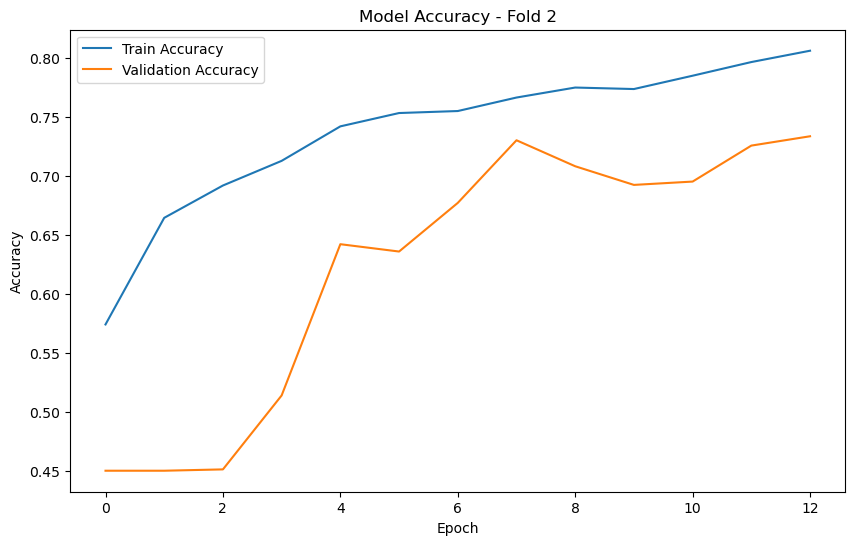

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 2 Results:
Accuracy: 0.7301
Balanced Accuracy: 0.7227
MCC: 0.4516
Sensitivity: 0.7967
Specificity: 0.6487

Learned track weights for fold 2:
Sequence weight: 0.5368
Structure weight: 0.4632

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5236 - loss: 1.1614 - val_accuracy: 0.5110 - val_loss: 0.8948 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6048 - loss: 0.8043 - val_accuracy: 0.5110 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6586 - loss: 0.7196 - val_accuracy: 0.5229 - val_loss: 0.9629 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7125 - loss: 0.6495 - val_accuracy: 0.6595 - val_loss: 0.7041 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7256 - loss: 0.6172 - val_accuracy: 0.7154 - val_loss: 0.6338 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7374 - loss: 0.6066 - val_accuracy: 0.7064 - val_loss: 0.6355 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7313 - loss: 0.5979 - val

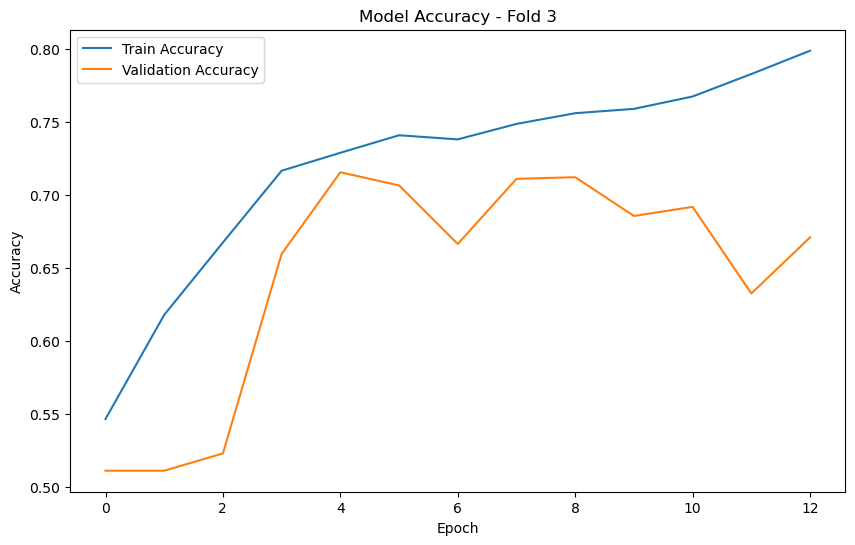

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7109
Balanced Accuracy: 0.7076
MCC: 0.4364
Sensitivity: 0.8575
Specificity: 0.5577

Learned track weights for fold 3:
Sequence weight: 0.5300
Structure weight: 0.4700

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5221 - loss: 1.1851 - val_accuracy: 0.5621 - val_loss: 0.8748 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6105 - loss: 0.8134 - val_accuracy: 0.4966 - val_loss: 0.8440 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6739 - loss: 0.7211 - val_accuracy: 0.6514 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7123 - loss: 0.6556 - val_accuracy: 0.6944 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7273 - loss: 0.6319 - val_accuracy: 0.7028 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7347 - loss: 0.6251 - val_accuracy: 0.7096 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7449 - loss: 0.6132 - val

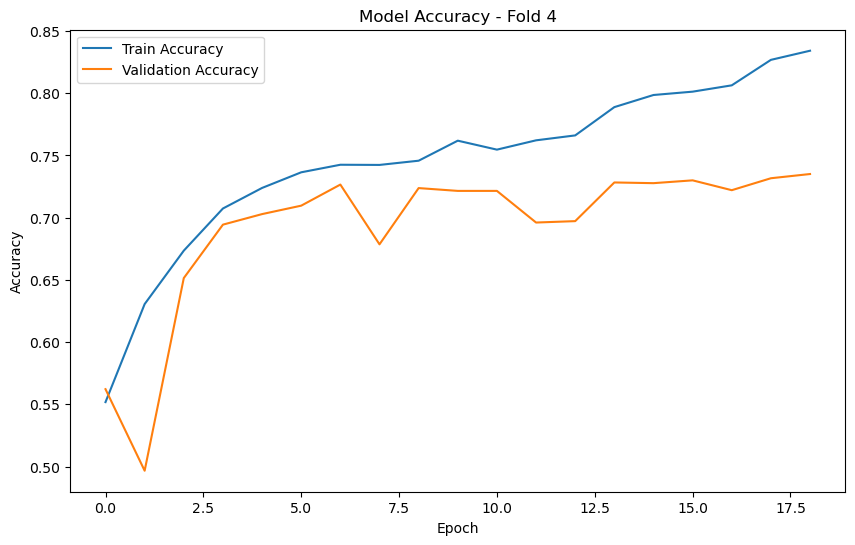

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7282
Balanced Accuracy: 0.7271
MCC: 0.4559
Sensitivity: 0.7651
Specificity: 0.6892

Learned track weights for fold 4:
Sequence weight: 0.5399
Structure weight: 0.4601

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5342 - loss: 1.1172 - val_accuracy: 0.4819 - val_loss: 0.8099 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6227 - loss: 0.7441 - val_accuracy: 0.5322 - val_loss: 0.7503 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6846 - loss: 0.6767 - val_accuracy: 0.6531 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7113 - loss: 0.6458 - val_accuracy: 0.6780 - val_loss: 0.6597 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7275 - loss: 0.6169 - val_accuracy: 0.7186 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7245 - loss: 0.6097 - val_accuracy: 0.7243 - val_loss: 0.6071 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7454 - loss: 0.5929 - val

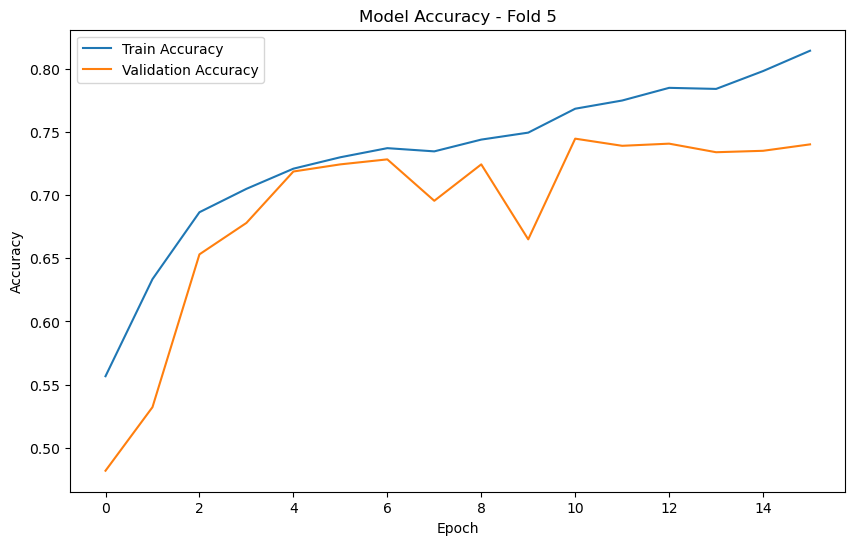

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7446
Balanced Accuracy: 0.7435
MCC: 0.4883
Sensitivity: 0.7754
Specificity: 0.7116

Learned track weights for fold 5:
Sequence weight: 0.5429
Structure weight: 0.4571

Average track weights across folds:
Sequence weight: 0.5378 ± 0.0044
Structure weight: 0.4622 ± 0.0044

Average Cross-validation Results:
ACC: 0.7242 ± 0.0137
BALANCED_ACC: 0.7216 ± 0.0136
MCC: 0.4494 ± 0.0241
SN: 0.7872 ± 0.0394
SP: 0.6560 ± 0.0533

Final Test Set Results:
Accuracy: 0.6814
Balanced Accuracy: 0.7275
MCC: 0.2668
Sensitivity: 0.7833
Specificity: 0.6716
Confusion Matrix:
[[1677  820]
 [  52  188]]


In [14]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=1)

Loading data...

Training set distribution:
label
1    4592
0    4261
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8853, 33)
X_train_struct: (8853, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8853,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.5287 - loss: 1.1492 - val_accuracy: 0.5630 - val_loss: 0.8318 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5985 - loss: 0.7936 - val_accuracy: 0.6059 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6655 - loss: 0.7047 - val_accuracy: 0.6894 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6877 - loss: 0.6728 - val_accuracy: 0.6465 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7059 - loss: 0.6401 - val_accuracy: 0.7058 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7237 - loss: 0.6202 - val_accuracy: 0.6776 - val_loss: 0.6713 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7310 - loss: 0

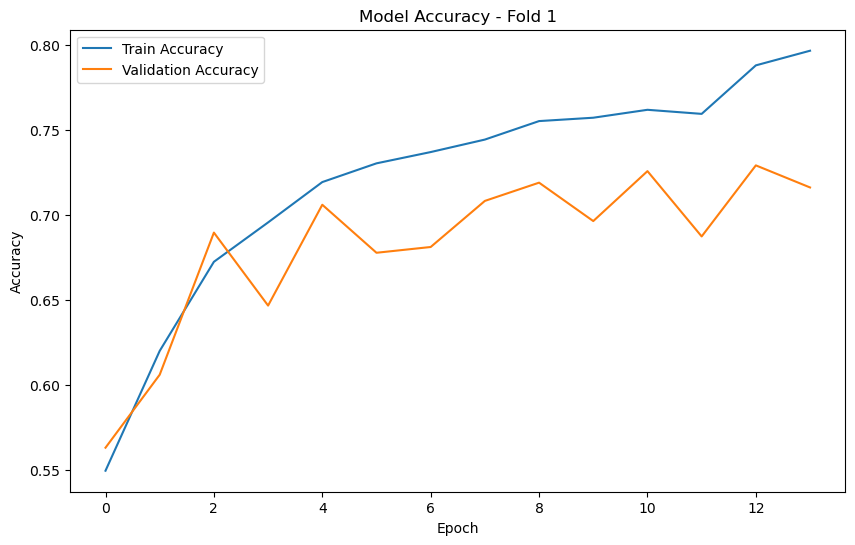

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 1 Results:
Accuracy: 0.7188
Balanced Accuracy: 0.7188
MCC: 0.4378
Sensitivity: 0.7322
Specificity: 0.7054

Learned track weights for fold 1:
Sequence weight: 0.5237
Structure weight: 0.4763

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.5288 - loss: 1.1744 - val_accuracy: 0.4523 - val_loss: 0.8871 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6128 - loss: 0.7932 - val_accuracy: 0.5155 - val_loss: 0.7685 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6690 - loss: 0.6988 - val_accuracy: 0.6539 - val_loss: 0.7048 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6853 - loss: 0.6679 - val_accuracy: 0.7194 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7144 - loss: 0.6311 - val_accuracy: 0.7165 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7263 - loss: 0.6003 - val_accuracy: 0.7239 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7382 - loss: 0.5936 - val

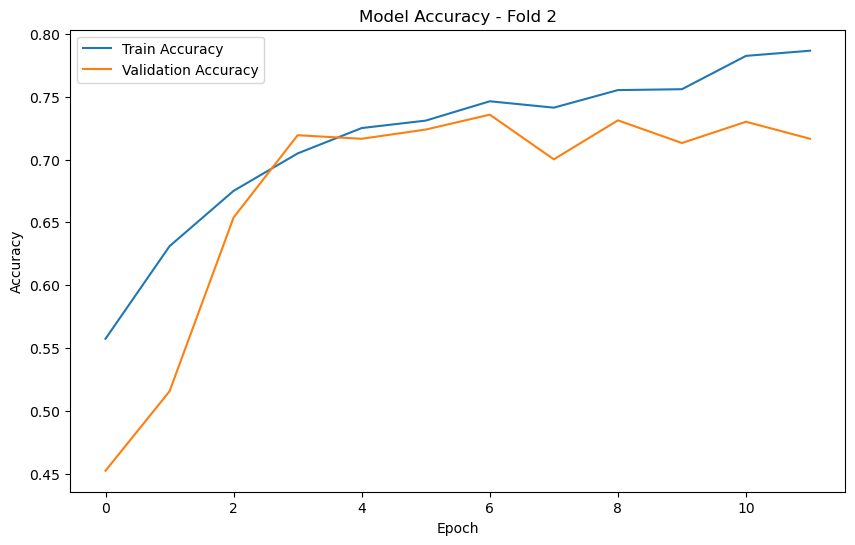

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7357
Balanced Accuracy: 0.7222
MCC: 0.4659
Sensitivity: 0.8573
Specificity: 0.5872

Learned track weights for fold 2:
Sequence weight: 0.5274
Structure weight: 0.4726

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5278 - loss: 1.1495 - val_accuracy: 0.5268 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6082 - loss: 0.7805 - val_accuracy: 0.4969 - val_loss: 0.8616 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6646 - loss: 0.7080 - val_accuracy: 0.6239 - val_loss: 0.7245 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7016 - loss: 0.6624 - val_accuracy: 0.6973 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7255 - loss: 0.6354 - val_accuracy: 0.6414 - val_loss: 0.7067 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7171 - loss: 0.6311 - val_accuracy: 0.7171 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7357 - loss: 0.6190 - val

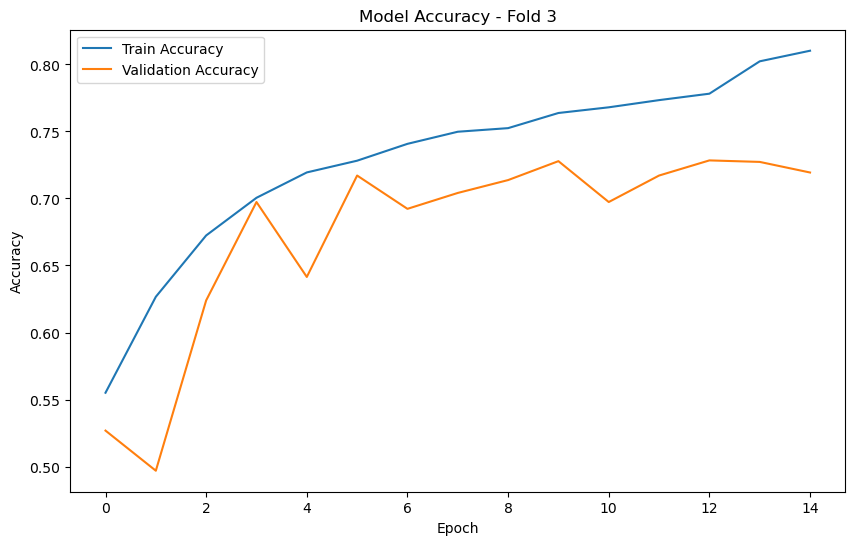

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7278
Balanced Accuracy: 0.7271
MCC: 0.4555
Sensitivity: 0.7613
Specificity: 0.6928

Learned track weights for fold 3:
Sequence weight: 0.5194
Structure weight: 0.4806

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.5276 - loss: 1.1528 - val_accuracy: 0.4853 - val_loss: 0.8929 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6466 - loss: 0.7794 - val_accuracy: 0.4853 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6954 - loss: 0.6712 - val_accuracy: 0.6531 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7307 - loss: 0.6209 - val_accuracy: 0.6644 - val_loss: 0.6734 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7509 - loss: 0.6058 - val_accuracy: 0.7136 - val_loss: 0.6315 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7455 - loss: 0.5901 - val_accuracy: 0.6559 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7492 - loss: 0.5882 - val

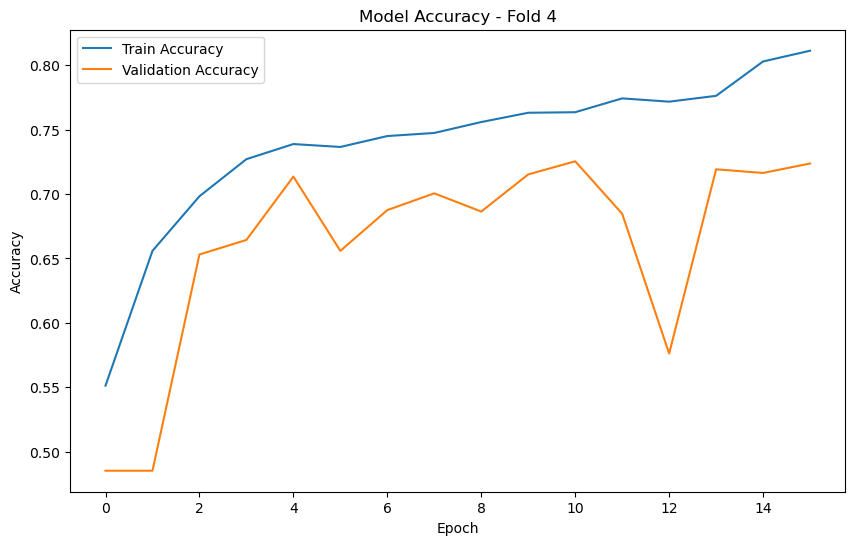

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 4 Results:
Accuracy: 0.7254
Balanced Accuracy: 0.7233
MCC: 0.4520
Sensitivity: 0.7947
Specificity: 0.6519

Learned track weights for fold 4:
Sequence weight: 0.5228
Structure weight: 0.4772

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.5485 - loss: 1.1426 - val_accuracy: 0.4819 - val_loss: 0.9555 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6334 - loss: 0.7727 - val_accuracy: 0.4842 - val_loss: 0.9996 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6711 - loss: 0.6981 - val_accuracy: 0.5582 - val_loss: 0.8167 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6953 - loss: 0.6858 - val_accuracy: 0.5565 - val_loss: 0.8105 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7235 - loss: 0.6345 - val_accuracy: 0.7232 - val_loss: 0.6093 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7316 - loss: 0.6237 - val_accuracy: 0.5588 - val_loss: 0.9091 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7366 - loss: 0.6166 - v

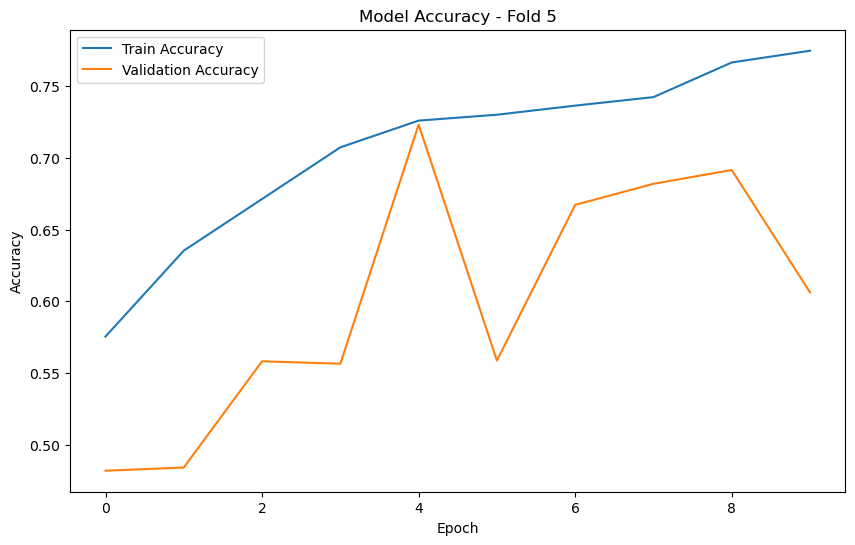

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 5 Results:
Accuracy: 0.7232
Balanced Accuracy: 0.7226
MCC: 0.4454
Sensitivity: 0.7372
Specificity: 0.7081

Learned track weights for fold 5:
Sequence weight: 0.5325
Structure weight: 0.4675

Average track weights across folds:
Sequence weight: 0.5252 ± 0.0045
Structure weight: 0.4748 ± 0.0045

Average Cross-validation Results:
ACC: 0.7262 ± 0.0056
BALANCED_ACC: 0.7228 ± 0.0026
MCC: 0.4513 ± 0.0095
SN: 0.7765 ± 0.0460
SP: 0.6691 ± 0.0456

Final Test Set Results:
Accuracy: 0.6880
Balanced Accuracy: 0.7235
MCC: 0.2636
Sensitivity: 0.7667
Specificity: 0.6804
Confusion Matrix:
[[1699  798]
 [  56  184]]


In [15]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=2)

In [16]:
# if __name__ == "__main__":
#     model = train_and_evaluate(struct_window=3)

In [17]:
# if __name__ == "__main__":
#     model = train_and_evaluate(struct_window=4)

In [18]:
# if __name__ == "__main__":
#     model = train_and_evaluate(struct_window=5)

In [19]:
# Run from the window size 5 to 10
# for struct_window in range(5, 11):
#     model = train_and_evaluate(struct_window=struct_window)
    

In [20]:
# window size 10 to 16
# for struct_window in range(10, 17):
#     model = train_and_evaluate(struct_window=struct_window)